<a href="https://colab.research.google.com/github/Agoroschuk/ML_tasks/blob/main/lab_2/lab02_part2_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accuracy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recommend to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

'cuda:0'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [ ]:
print(type(fmnist_dataset_train))
print(type(fmnist_dataset_test))
print(len(fmnist_dataset_train))
print(len(fmnist_dataset_test))
print(type(fmnist_dataset_test[0]))
print('looking at train sample', fmnist_dataset_train[0][0][0][0])

<class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'torchvision.datasets.mnist.FashionMNIST'>
60000
10000
<class 'tuple'>
looking at train sample tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [ ]:
fmnist_dataset_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fmnist
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
# аналог get_batches из main_notebook
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=512,
                                           shuffle=True,
                                           num_workers=2) # кол-во подпроцессов загрузки данных
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=512,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
# torch.utils.data.DataLoader??

In [ ]:
print(len(train_loader))
print(len(test_loader))

469
40


In [ ]:
# данные заново перемешиваются при каждом вызове
# У DataLoader вроде 2 важных метода: len и getitem
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    print('label value itself', label)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128
label value itself tensor([3, 7, 9, 9, 6, 1, 7, 6, 7, 2, 2, 9, 4, 0, 4, 3, 7, 6, 2, 2, 9, 8, 2, 4,
        5, 7, 4, 9, 5, 0, 2, 2, 8, 1, 8, 6, 5, 9, 1, 8, 1, 1, 3, 0, 6, 9, 0, 5,
        5, 5, 8, 0, 8, 0, 9, 9, 2, 9, 2, 2, 5, 2, 7, 4, 0, 9, 3, 9, 5, 0, 8, 8,
        8, 3, 2, 3, 1, 3, 1, 6, 6, 6, 8, 2, 6, 4, 2, 4, 2, 1, 5, 1, 1, 5, 3, 0,
        7, 8, 9, 6, 2, 0, 6, 7, 9, 7, 7, 0, 3, 2, 8, 8, 3, 7, 3, 7, 4, 7, 7, 6,
        0, 4, 9, 0, 9, 9, 2, 8])


In [ ]:
toy_img_tensor = torch.zeros(1, 28, 28)
print(toy_img_tensor.shape)
toy_img_flatten_tensor = torch.flatten(toy_img_tensor)
print(toy_img_flatten_tensor.shape)

torch.Size([1, 28, 28])
torch.Size([784])


In [ ]:
# torch.flatten??

### Task 1. Any network
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            # 1 сверточный блок (извлекает простые признаки)
            nn.Unflatten(1, (1, 28, 28)),
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), #28,28 ->14, 14
            nn.Dropout(0.2),

            # 2 сверточный блок извлекает более сложные признаки)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14,14 -> 7,7
            nn.Dropout(0.2),

            # Полносвязный блок
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
         Unflatten-2            [-1, 1, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]             320
       BatchNorm2d-4           [-1, 32, 28, 28]              64
              ReLU-5           [-1, 32, 28, 28]               0
            Conv2d-6           [-1, 32, 28, 28]           9,248
       BatchNorm2d-7           [-1, 32, 28, 28]              64
              ReLU-8           [-1, 32, 28, 28]               0
         MaxPool2d-9           [-1, 32, 14, 14]               0
          Dropout-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 64, 14, 14]          18,496
      BatchNorm2d-12           [-1, 64, 14, 14]             128
             ReLU-13           [-1, 64, 14, 14]               0
           Conv2d-14           [-1, 64,

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_func = nn.CrossEntropyLoss()

In [ ]:
def train_model(
    train_loader,
    test_loader,
    n_epoch,
    optimizer,
    loss_fn
    ):
    '''
    Состоит из прохода по батчам в рамках каждой эпохи train_loader и test_loader
    Проход по test_loader с отключенным вычислительным графом (with torch.no_grad), Dropout и Batchnorm (model.eval())
    '''
    train_loss, test_loss, train_acc, test_acc = [], [], [], []
    model.train()
    for epoch in range(n_epoch):
        train_loss_epoch, test_loss_epoch, train_acc_epoch, test_acc_epoch = [], [], [], []

        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # обнуляем градиенты, чтобы они не накапливались с прошлых шагов, и сеть училась корректно
            optimizer.zero_grad()
            # forward
            predictions = model(X_batch)
            loss = loss_fn(predictions, Y_batch)
            # backward
            loss.backward()
            # gradient descent
            optimizer.step()
            # item() converts tensor from 1 element to python number
            train_loss_epoch.append(loss.item())
            # cравниваем, у какой метки по предсказанию наибольший скор и истинную метку
            train_acc_epoch.append((predictions.argmax(dim=1) == Y_batch).float().mean().item())

        # отключение batchnorm, dropout
        model.eval()
        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, Y_batch)
                test_loss_epoch.append(loss.item())
                test_acc_epoch.append((predictions.argmax(dim=1) == Y_batch).float().mean().item())

        #получаем усредненные по батчу значения в пределах эпохи
        train_loss.append(np.mean(train_loss_epoch))
        train_acc.append(np.mean(train_acc_epoch))
        test_loss.append(np.mean(test_loss_epoch))
        test_acc.append(np.mean(test_acc_epoch))

    return train_loss, test_loss, train_acc, test_acc

In [ ]:
def plot(train_loss, test_loss, train_acc, test_acc):
    plt.figure(figsize=(14,10))

    # (кол-во строк, кол-во столбцов, позиция текущего элемента)
    plt.subplot(2, 2, 1)
    plt.title('Train and test accuracy')
    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy')
    plt.plot(train_acc, 'c', label='Train accuracy')
    plt.plot(test_acc, 'm', label='Test accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title('Train and test loss')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.plot(train_loss, 'c', label='Train loss')
    plt.plot(test_loss, 'm', label='Test loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
%%time
n_epoch = 10
train_loss, test_loss, train_acc, test_acc = train_model(train_loader, test_loader, n_epoch, opt, loss_func)

CPU times: user 40.5 s, sys: 4.6 s, total: 45.1 s
Wall time: 2min 11s


In [ ]:
print(train_acc[-1])
print(test_acc[-1])

0.9921985349412692
0.921605008840561


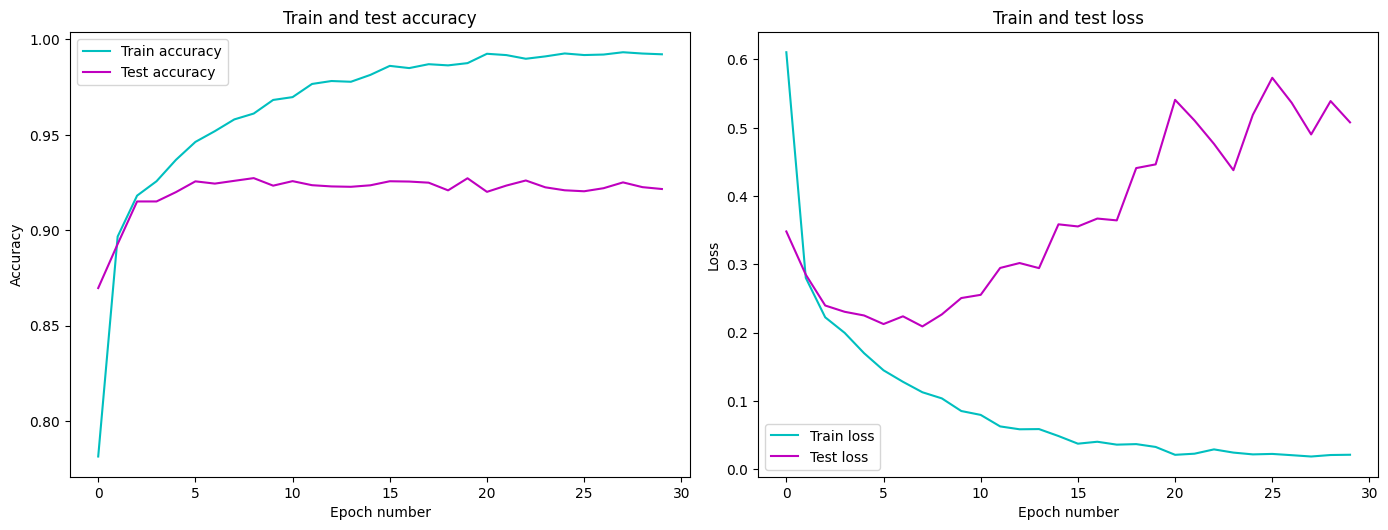

In [ ]:
plot(train_loss, test_loss, train_acc, test_acc)

In [ ]:
print('Лучший accuracy был достигнут на эпохе:', np.argmax(test_acc))
print('Значение accuracy', test_acc[5])

Лучший accuracy был достигнут на эпохе: 8
Значение accuracy 0.9256204038858413


**Вывод**
1. Итоговый accuracy около 92,5%, что является не самым плохим результатом для данной задачи.
2. Можно попробовать улучшить архитектуру, чтобы повысить accuracy
3. Были произведены эксперименты с train batch_size = 128/256/512, learning rate 1e-4, 2e-4, 2e-3, 1e-3. При выбранной архитектуре это не принесло роста accuracy или сближения кривых train и test

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accuraсy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=2) # кол-во подпроцессов загрузки данных
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
class OverfittingNeuralNetwork(nn.Module): # max overfit
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, num_classes)
        )

    def forward(self, inp):   # зачем эта функция?
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
       BatchNorm1d-3                  [-1, 500]           1,000
              ReLU-4                  [-1, 500]               0
            Linear-5                  [-1, 400]         200,400
       BatchNorm1d-6                  [-1, 400]             800
              ReLU-7                  [-1, 400]               0
            Linear-8                  [-1, 300]         120,300
       BatchNorm1d-9                  [-1, 300]             600
             ReLU-10                  [-1, 300]               0
           Linear-11                  [-1, 200]          60,200
      BatchNorm1d-12                  [-1, 200]             400
             ReLU-13                  [-1, 200]               0
           Linear-14                  [

Your experiments come here:

In [ ]:
model = OverfittingNeuralNetwork().to(device, torch.float32)

In [ ]:
# module - экземпляр класса nn.Sequential, nn.Sequential наследуется от nn.Module,
# метод parameters() есть в nn.Module
import inspect

print(inspect.getsource(nn.Module.parameters))

    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
        r"""Return an iterator over module parameters.

        This is typically passed to an optimizer.

        Args:
            recurse (bool): if True, then yields parameters of this module
                and all submodules. Otherwise, yields only parameters that
                are direct members of this module.

        Yields:
            Parameter: module parameter

        Example::

            >>> # xdoctest: +SKIP("undefined vars")
            >>> for param in model.parameters():
            >>>     print(type(param), param.size())
            <class 'torch.Tensor'> (20L,)
            <class 'torch.Tensor'> (20L, 1L, 5L, 5L)

        """
        for _name, param in self.named_parameters(recurse=recurse):
            yield param



In [ ]:
model = OverfittingNeuralNetwork().to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [ ]:
# torch.optim.Adam??
from torch.optim._functional import adam

In [ ]:
%%time
n_epoch = 30
train_loss, test_loss, train_acc, test_acc = train_model(train_loader, test_loader, n_epoch, opt, loss_func)

CPU times: user 1min 52s, sys: 12 s, total: 2min 4s
Wall time: 2min 26s


In [ ]:
# Переобучилась сильно
print(train_acc[-1])
print(test_acc[-1])

0.9518256929637526
0.8912109375


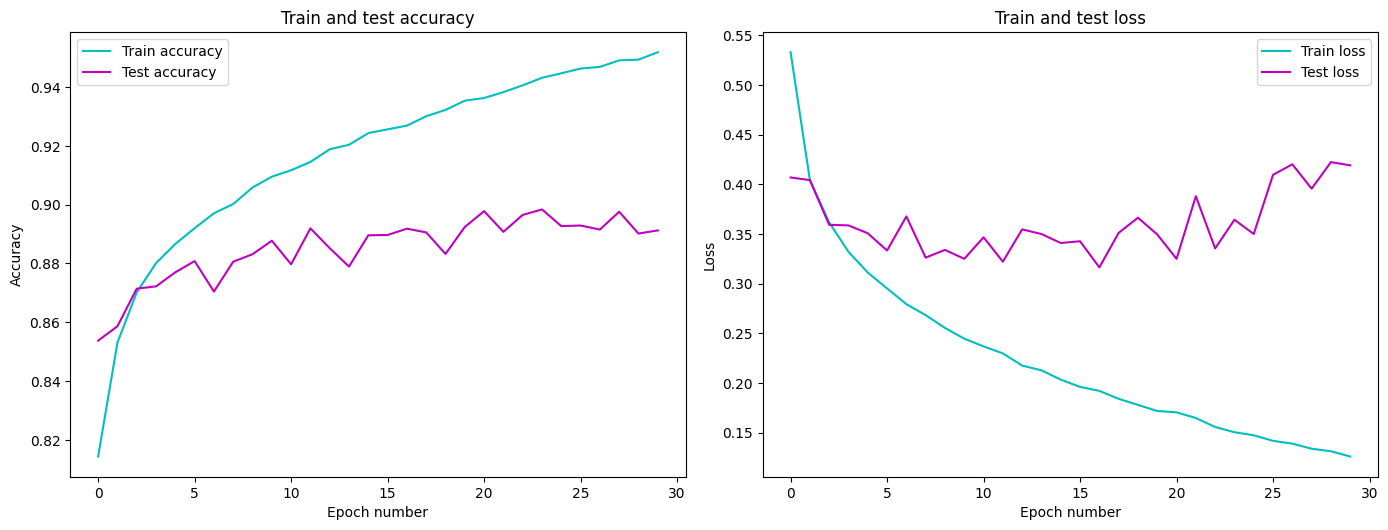

In [ ]:
plot(train_loss, test_loss, train_acc, test_acc)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 100]          12,900
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 247,766
Trainable params: 247,766
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.95
Estimated Total Size (MB): 0.96
----------------------------------------------------------------


In [ ]:
# Your experiments, come here
model = FixedNeuralNetwork().to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()

In [ ]:
%%time
n_epoch = 30
train_loss, test_loss, train_acc, test_acc = train_model(train_loader, test_loader, n_epoch, opt, loss_func)

CPU times: user 1min 16s, sys: 11.4 s, total: 1min 28s
Wall time: 2min 18s


In [ ]:
print(train_acc[-1])
print(test_acc[-1]) # очень простая сеть

0.9292877132196162
0.88935546875


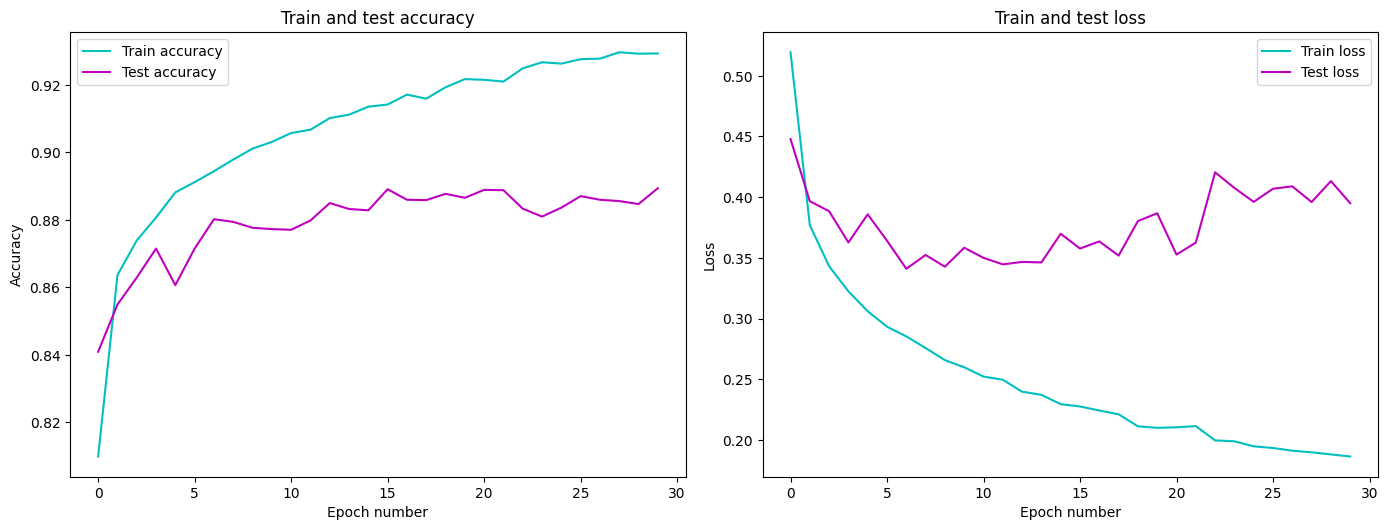

In [ ]:
plot(train_loss, test_loss, train_acc, test_acc)

### Conclusions:
_Write down small report with your conclusions and your ideas._

**Выводы и комментарии**
1. Удалось снизить переобучения с пары (accuracy_train, accuracy_test) (0.952, 0.891) до (0.930, 0.890) при одинаковых batch size (64 train, 256 test)
2. Более простая архитектура вовсе без BatchNorm и Dropout позволила снизить переобучение. Это было неожиданно и пока до конца не ясно.
3. Сравнения получены на 30 эпохе обучения


In [ ]:
# Архитектура с наиболее высоким уровним переобучения, которое удалось достичь в процессе экспериментов
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
       BatchNorm1d-3                  [-1, 500]           1,000
              ReLU-4                  [-1, 500]               0
            Linear-5                  [-1, 400]         200,400
       BatchNorm1d-6                  [-1, 400]             800
              ReLU-7                  [-1, 400]               0
            Linear-8                  [-1, 300]         120,300
       BatchNorm1d-9                  [-1, 300]             600
             ReLU-10                  [-1, 300]               0
           Linear-11                  [-1, 200]          60,200
      BatchNorm1d-12                  [-1, 200]             400
             ReLU-13                  [-1, 200]               0
           Linear-14                  [

In [ ]:
# Архитектура, на которой удалось снизить переобучение
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 100]          12,900
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 247,766
Trainable params: 247,766
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.95
Estimated Total Size (MB): 0.96
----------------------------------------------------------------
